In [1]:
# Objective of this project:
# Expectation
    # On the basis of text entered, a user receives Tags which are offered to him
    # These Tags are used to characterize the entered document
    # The mechanism should be as follows:
        # 1. Unsupervised method such as LDA (latent dirichlet allocation) to create topics
        # 2. These topics are docs considered the X
        # 3. A supervised RF-type method must make it possible to predict Tags
            # The Xs are the Topics obtained by LDA
            # There are Tags originally
    # It is necessary to develop metrics:
        # https://scikit-learn.org/stable/modules/model_evaluation.html
        # Use sckikilearn multilabel

# Source:
# SELECT Id, Body, Title, Tags FROM posts WHERE Id <50000 AND Score> = 5 AND Tags IS NOT NULL
# https://data.stackexchange.com/stackoverflow/query/edit/1288874    

# This Noteboook is the one corresponding to Notebook 2

# The structure of notebooks is as follows:
# Notebook 1
# - Text cleaning for X and y (includes univariate and multivariate analysis)
# - Extraction of all words from texts and titles to identify the 25 most used
# - Multilabel binarizer of y
# - Tf-idf of Xs
# - Univariate and multivariate analysis of Xs
# - Univariate and multivariate analysis of Ys, in particular via a PCA
# - Export my X and y in df format

# Notebook 2 vdef
# - Split train-test (2 collar for the X and 2 collar for the y)
# - LDA base train: Objective = avoid overfitting of Xs, obtained prediction of Xs via unsupervised method
# - From the LDA matrix: One vs Rest (Random Forest Classifier) ​​to predict the ys - OvR: because y = multilabel
        # predict rf / y_test which allows me to get a prediction matrix
        # ==> objective: predict y_test (avoid overfitting ys)
# Production of metrics (F1, Log Loss, Hamming loss)
# Based on a text (X),
    # predict main topics via lda
    # predict Tags (Ys) via OvR (RF)

In [2]:
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

# Checking the version
import sklearn
sklearn.__version__

# 2. Load the packages
import numpy as np
import pandas as pd

In [3]:
# Section 1: Import source and transformed data during the 1st Notebook
# For the X = Clean texts
# For y = Cleaned Tags and Binarized Multi Label

In [4]:
# Step 1: import data  source
df_y_cleaned= pd.read_csv('P6_df_y.csv')
df_X_cleaned = pd.read_csv('P6_df_X.csv')
df_y_mlb = pd.read_csv('P6_df_y_vctzd.csv')
df_y_vctzd_tagsclnd = pd.read_csv('P6_df_y_vctzd_tagclnd.csv')

In [5]:
df_y_mlb.head(2)

,Unnamed: 0,.net,asp.net,c,c#,c++,css,database,html,java,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Step 2: Transformation of the data loaded in df
df_X_cleaned = df_X_cleaned.drop(df_X_cleaned.columns[0], axis=1)
df_y_cleaned = df_y_cleaned.drop(df_y_cleaned.columns[0], axis=1)
df_y_mlb = df_y_mlb.drop(df_y_mlb.columns[0], axis=1)
df_y_vctzd_tagsclnd = df_y_vctzd_tagsclnd.drop(df_y_vctzd_tagsclnd.columns[0], axis=1)

In [7]:
df_y_vctzd_tagsclnd.head(3)

,AllTags,tags_list,corrected_tags_list,.net,asp.net,c,c#,c++,css,database,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
0,c# floating-point type-conversion double decimal,"['c#', 'floating-point', 'type-conversion', 'd...",['c#'],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,html css internet-explorer-7,"['html', 'css', 'internet-explorer-7']","['html', 'css']",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,c# .net datetime,"['c#', '.net', 'datetime']","['c#', '.net']",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data = df_X_cleaned.content.values.tolist()

In [9]:
# Step 3: Vectorization of the Xs for the LDA

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_x = CountVectorizer(analyzer="word",
                             max_features=1500,
                             # min_df=0.05,
                             max_df=0.9,
                             # stop_words=stopwords.words('english'),
                             # tokenizer = None,
                             # preprocessor = None,
                             )
data_vectorized = vectorizer_x.fit_transform(data)            
X = vectorizer_x.fit_transform(data).toarray()
# We get the column names variable X
ColName_X = list(vectorizer_x.vocabulary_.keys())[:1500]
ColName_X[0:10]

['want',
 'use',
 'track',
 'bar',
 'change',
 'form',
 'code',
 'decimal',
 'value',
 'this']

In [10]:
ColName_X = list(vectorizer_x.vocabulary_.keys())[:1500]

In [11]:
df_X= pd.DataFrame(X, columns = ColName_X)

In [12]:
df_y_vctzd_tagsclnd.head(4)

,AllTags,tags_list,corrected_tags_list,.net,asp.net,c,c#,c++,css,database,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
0,c# floating-point type-conversion double decimal,"['c#', 'floating-point', 'type-conversion', 'd...",['c#'],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,html css internet-explorer-7,"['html', 'css', 'internet-explorer-7']","['html', 'css']",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,c# .net datetime,"['c#', '.net', 'datetime']","['c#', '.net']",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,c# datetime time datediff relative-time-span,"['c#', 'datetime', 'time', 'datediff', 'relati...",['c#'],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df_y_vctzd_noTags = df_y_vctzd_tagsclnd.drop(['AllTags', 'tags_list', 'corrected_tags_list'], axis = 1)

In [14]:
# Section 2 : split train test
from sklearn.model_selection import train_test_split
# 2.1 Separation of bases in process and test. Here, X and y are in 2 different data sets
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y_vctzd_noTags, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2708, 1500)
(1161, 1500)
(2708, 25)
(1161, 25)


In [15]:
# Section 3: Implementation of MultilabelBinarizer, LDA and RF prediction process

In [17]:
# Step 1: LDA on data set train (avoid overfitting of Xs)
# 1.1 Import of libraries for visualization of results
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import timeit

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# 1.2 Start of process
start_time_lda_RF = timeit.default_timer()

# 1.3 LDA on train base
lda_model = LatentDirichletAllocation(n_components=10, # Number of topics
                                      max_iter=10,  # Max learning iterations
                                      learning_method='online',                       
                                      random_state=100, # Random state
                                      batch_size=128,  # n docs in each learning iter
                                      evaluate_every = -1,  # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,  # Use all available CPUs
                                     )
lda_output_train = lda_model.fit_transform(X_train) # LDA on train base

print(lda_model)  # Model attributes

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [19]:
# Vérification
lda_output_train.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2708, 10)

In [20]:
# Step 2: Diagnosis of the model's performance (log likelihood and perplexity)

print("Log Likelihood: ", lda_model.score(X_train))

# Reminder on the metric "Perplexity" (Lower the better) 
    # Perplexity is a statistical measure of how well a probability model predicts a sample. 
    # As applied to LDA, for a given value of , you estimate the LDA model. 
    # Then given the theoretical word distributions represented by the topics, 
    # compare that to the actual topic mixtures, or distribution of words in your documents.

print("Perplexity: ", lda_model.perplexity(X_train))
pprint(lda_model.get_params())

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -835617.9289891301
Perplexity:  847.8595644812264
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [21]:
# Step 3: find the best parameter with GridSearch

# Final version : search_params = {'n_components': [10, 15, 20], 'learning_decay': [.5, .7, .9]}

search_params = {'n_components': [10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Model initialization
lda = LatentDirichletAllocation()

# Initialization of Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Let's do the GridSearch
model.fit(X_train)

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [22]:
# Step 4: Display the best settings

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_train))

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -187013.01975719797
Model Perplexity:  828.2672797901375


/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


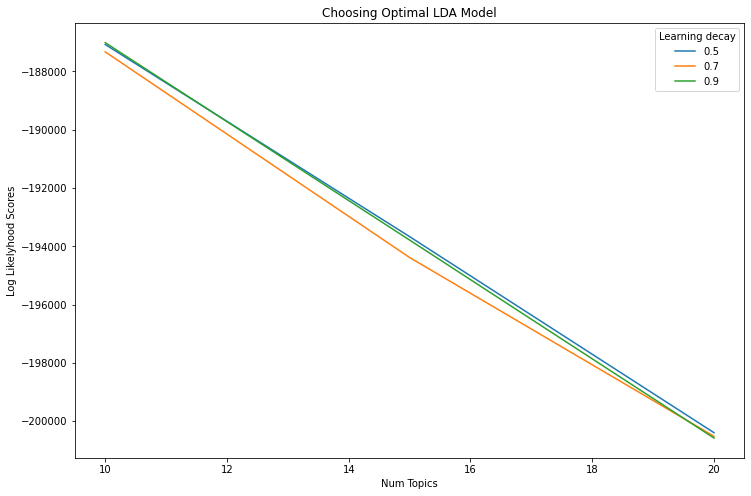

In [23]:
# Step 5: Compare the best performances by parameter (loglikelihood)

# n_components = [10, 15, 20]
n_components = [10, 15, 20]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay'] == 0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay'] == 0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay'] == 0.9]

# Graph display
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()
# The graph indicates the optimal number of topics (close to 10)
# For the final model, it would take n_components = 10

In [24]:
X_test.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1161, 1500)

In [25]:
# Step 6: I did the LDA on the X_test data set: predict the Xs without overfit

# Creation of the doc matric of the topics
lda_output_test = best_lda_model.transform(X_test)


# Column name
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# Index name
docnames = ["Doc" + str(i) for i in range(len(X_test))]

# Create a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output_test, 2), columns=topicnames, index=docnames)
df_document_topic.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1161, 10)

In [26]:
# Step 7: Obtaining and displaying the dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

# Below are the dominant topics predicted on the Xs from the LDA method
# I predict the Xs because LDA is an unsupervised method (there is unknown, unlike supervised methods)
# The objective is to sprint Xs by avoiding the overfitting of Xs

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.320000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.480000,0.000000,0.070000,7
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.450000,0.290000,0.000000,0.000000,0.220000,5
Doc2,0.010000,0.010000,0.010000,0.010000,0.010000,0.120000,0.010000,0.800000,0.010000,0.010000,7
Doc3,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.210000,0.000000,0.170000,0.000000,4
Doc4,0.260000,0.000000,0.000000,0.000000,0.180000,0.000000,0.360000,0.000000,0.180000,0.000000,6
Doc5,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.910000,0.000000,0.000000,7
Doc6,0.000000,0.050000,0.070000,0.110000,0.000000,0.000000,0.050000,0.720000,0.000000,0.000000,7
Doc7,0.000000,0.000000,0.290000,0.000000,0.000000,0.000000,0.000000,0.690000,0.000000,0.000000,7
Doc8,0.100000,0.000000,0.000000,0.000000,0.000000,0.090000,0.110000,0.360000,0.000000,0.330000,7
Doc9,0.010000,0.010000,0.330000,0.310000,0.010000,0.320000,0.010000,0.010000,0.010000,0.010000,2


In [27]:
df_document_topic.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1161, 11)

In [28]:
# Step 8: Display the distribution of topics
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic Num,Num Documents
0,7,364
1,6,166
2,0,154
3,3,130
4,9,91
5,8,85
6,5,53
7,4,44
8,1,44
9,2,30


In [29]:
pprint(data[2:3])

["given datetime type representing person's birthday calculate age years c# "
 "calculate someone's age based datetime type birthday"]


/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Step 9: Viewing lda topics via pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer_x, mds='tsne')
panel

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  24.004360
6       0.648955  71.707100       2        1  14.220582
0      71.019684   9.971006       3        1  12.195969
3       3.785981  33.185135       4        1  10.589306
8     -42.666500  -9.222070       5        1   8.470285
9      -3.621689 -43.526516       6        1   7.913922
5      -3.632402  -4.171708       7        1   6.298677
4     -36.584400  35.804413       8        1   5.617710
1      44.391380  50.615383       9        1   5.444875
2      40.235809 -31.591665      10        1   5.244315, topic_info=             Term         Freq        Total Category  logprob  loglift
860           net  1221.000000  1221.000000  Default  30.0000  30.0000
1235          sql   708.000000   708.000000  Default  29.0000  29.0000
320      database   740.000000   740.000000  Default  28.0000  28.0000
100           asp   505.000000   505.000000  Default  27.0000  27.0000
1172       server   907.000000   907.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1410        using    77.836399  1729.926581  Topic10  -4.7848  -0.1532
734          like    76.411402  1786.650359  Topic10  -4.8033  -0.2039
78    application    65.414420   850.852125  Topic10  -4.9587   0.3825
1379         type    55.996920   529.205911  Topic10  -5.1141   0.7019
233          code    59.900778  1360.484648  Topic10  -5.0467  -0.1749

[603 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         9  0.986940    00
1         3  0.940754   000
2         7  0.972612  0000
9         4  0.861530  2000
9         5  0.063817  2000
...     ...       ...   ...
1492      6  0.895135    xp
1493      9  0.974607    xs
1494      2  0.135588   xsl
1494      7  0.058109   xsl
1494     10  0.774790   xsl

[1969 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 1, 4, 9, 10, 6, 5, 2, 3])

In [31]:
# Step 10: Display topic keywords
# The weight of each keyword in each topic is contained in the LDA model
# components_ as a 2d array.
# Keywords can be obtained from the vectorizer object using get_feature_names ()

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer_x.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,00,000,0000,10,100,11,12,15,20,2000,...,www,xml,xp,xs,xsl,year,years,yes,yet,zip
Topic0,0.100013,14.015459,0.100002,22.482913,0.100353,0.100024,19.075349,1.299836,10.678096,0.123319,...,0.100003,128.914584,0.100124,0.100002,0.100010,0.100008,1.136205,2.145814,8.845338,8.027191
Topic1,45.099925,0.100000,0.100006,16.761888,4.559767,8.244549,6.746607,8.726940,1.818264,0.100013,...,0.100001,25.143343,0.100004,42.099998,0.100005,6.830383,9.535243,0.100039,8.782581,0.100032
Topic2,0.100045,0.100001,0.100000,0.100042,2.830578,5.043009,4.584485,3.862236,3.204152,0.100002,...,132.325012,14.210920,0.100009,0.100000,30.628327,0.100009,0.100005,5.388992,0.100800,10.176236
Topic3,0.100000,0.100032,0.100000,0.100035,4.970040,0.814225,2.291940,4.917248,19.082618,19.016345,...,0.100001,0.100009,0.100003,0.100000,0.100005,0.100033,9.191877,1.537730,7.740843,0.100039
Topic4,0.100003,0.100000,0.100000,0.724825,5.989976,0.100012,0.100017,5.195740,0.100014,0.100000,...,0.100004,2.263858,0.100008,0.100000,0.100023,0.100016,8.246057,0.100040,12.979012,0.100005


In [32]:
# Step 11: Display the 15 keywords of each topic
# Display n_key_words for each topic
def show_topics(vectorizer=vectorizer_x, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(
    vectorizer=vectorizer_x, lda_model=best_lda_model, n_words=15)

# df Topic - Keywords
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i)
                             for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i)
                           for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,file,data,like,way,files,would,using,code,xml,something,application,want,need,best,line
Topic 1,use,control,svn,using,java,version,regex,anyone,one,build,tools,changes,like,source,match
Topic 2,script,http,js,com,www,would,src,ruby,ru,os,source,wpf,site,use,using
Topic 3,server,database,sql,table,data,use,key,way,one,using,mysql,tables,access,would,client
Topic 4,option,one,text,like,select,way,ve,would,using,tree,search,find,work,main,git
Topic 5,net,asp,page,web,mvc,form,eclipse,java,url,using,request,way,action,system,like
Topic 6,string,value,public,class,int,function,way,object,name,return,list,new,like,foo,id
Topic 7,use,code,would,like,ve,good,using,know,one,class,test,java,time,used,question
Topic 8,javascript,web,html,page,div,using,css,user,browser,use,dll,image,application,display,like
Topic 9,windows,visual,studio,system,run,error,get,project,using,running,way,2008,settings,net,build


In [33]:
# Step 12: Display the cluster of docs which have similar topics
# Build clusters using k-mean
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output_train)

# Build the Singular Value Decomposition (SVD) model
svd_model = TruncatedSVD(n_components=2, algorithm = 'arpack')# 2 components, by default algorithm = 'randomized', tested with 'arpack'
lda_output_svd = svd_model.fit_transform(lda_output_train)

# We use the SVD decomposition to display the X and Y axes of the point cloud
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weight of the 20 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of variance explained in lda_output explained by 2 components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Component's weights: 
 [[ 0.2   0.17  0.26  0.54  0.68  0.09  0.23  0.19  0.09  0.11]
 [ 0.01 -0.03  0.    0.77 -0.63  0.05 -0.03  0.04  0.01  0.  ]]
Perc of Variance Explained: 
 [0.05 0.26]


/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Segregation of Topic Clusters')

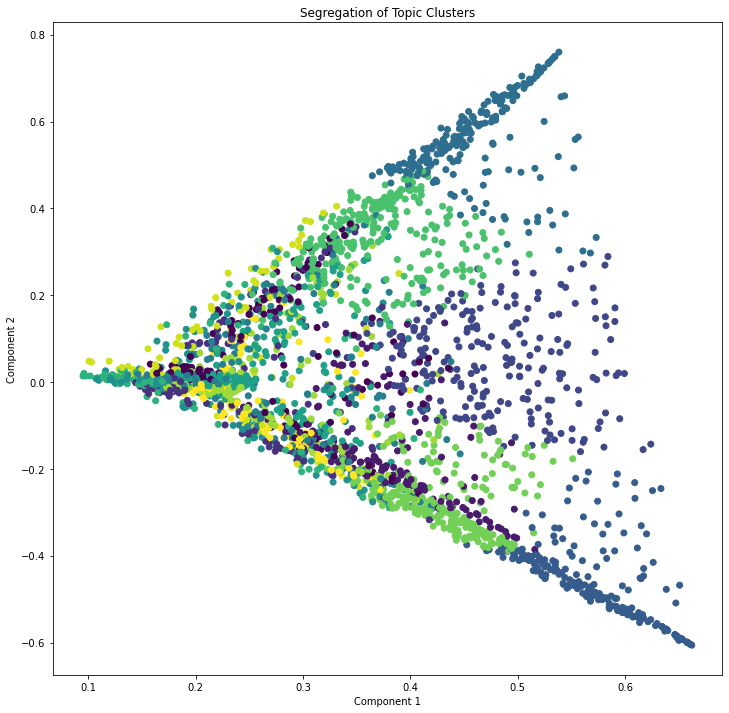

In [34]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
# No outliers, that's good.

In [35]:
# Section 3: Running the supervised RF forecast model to predict the y

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Step 1: Importing libraries
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.model_selection import train_test_split 
import warnings

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# Step 2: Some checking of the structure of the matrices obtained via lda and split train-test
lda_output_test.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1161, 10)

In [38]:
lda_output_test

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.32142432, 0.00119069, 0.00119087, ..., 0.48414172, 0.0011908 ,
        0.06836965],
       [0.00454647, 0.00454594, 0.00454714, ..., 0.00454645, 0.00454673,
        0.2227435 ],
       [0.01000106, 0.01000065, 0.01000497, ..., 0.79563319, 0.01000288,
        0.01000033],
       ...,
       [0.00322647, 0.15160745, 0.00322677, ..., 0.00322676, 0.00322708,
        0.29395297],
       [0.00222253, 0.00222311, 0.00222238, ..., 0.31503935, 0.03282471,
        0.0022224 ],
       [0.01666926, 0.01667234, 0.01666766, ..., 0.01666879, 0.0166676 ,
        0.01667467]])

In [39]:
lda_output_train.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2708, 10)

In [40]:
y_train

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,.net,asp.net,c,c#,c++,css,database,html,java,javascript,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
1053,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3212,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1731,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1309,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1294,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3507,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [41]:
# Step 3: Set up prediction models
# As y = binarized multilabel, you have to use One vs Rest
from sklearn.ensemble import RandomForestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier())

# Tag prediction
y_score = classifier.fit(lda_output_train, y_train).predict(lda_output_test)

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Step 4: some checks of the outputs obtained
lda_output_train.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2708, 10)

In [43]:
y_train.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2708, 25)

In [44]:
lda_output_test.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1161, 10)

In [45]:
y_score.shape

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1161, 25)

In [46]:
y_score

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:
# Step 5: Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
print(f"Test Set Accuracy : {accuracy_score(y_test, y_score) * 100} %\n\n") 
# print(f"Classification Report : \n\n{classification_report(y_test, y_score)}") 

Test Set Accuracy : 25.32299741602067 %




/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
print(f"Test log_loss : {log_loss(y_test, y_score) * 100} %\n\n")

hlrfc = hamming_loss(y_test, y_score)
hl_1 = 1-hlrfc

print('1-Hamming loss rfc', (hl_1))

Test log_loss : 510.0036755689064 %


1-Hamming loss rfc 0.9570025839793281


/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
elapsed_lda_RF = timeit.default_timer() - start_time_lda_RF
print('time for processing : {:.2f}s'.format(elapsed_lda_RF)) # 365 s = 6 min

time for processing : 554.77s


/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# Section 4: Model simulation for a new typed text

# Step 1: Import the libraries and ask not to display some warning messages
# Librairies
import re
import re, nltk, spacy, gensim
import pickle
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [51]:
# Step 2: Cleaning and vectorization of the entered text
# 2.1 Function
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True supprime les ponctuations

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# 2.2 Lemmatization 
def lemmatization(texts, allowed_postags=['NOUN']): # Original ['NOUN', 'ADJ', 'VERB', 'ADV'] # Lemmatization pour seulement les noms
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en', disable=['parser', 'ner']) # spacy 'en' model, conserve seulement les composants (for efficiency)

/Users/safiurrehman/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [52]:
# Start of process time
start_time_NewTag = timeit.default_timer()

In [53]:
# Step 3: Tag prediction based on lda output

# 3.1 Define a function which predicts the topic for a given doc
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN']) # Original ['NOUN', 'ADJ', 'VERB', 'ADV'] 

    # Step 3: Vectorize transform
    mytext_4 = vectorizer_x.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores


# Topic prediction
# Some texts entered for testing
    # How can optimize query when use ORDER BY on varchar column
    # CSS Python C ++
    # Python XML to Json
    # "<p> SQL Server - any equivalent of Excel's CHOOSE function VB.NET.? * @ <p>",
         # "Berkeley-db How to free c ++ memory vector <int> * arr? Vb6"

mytext = ["CSS Python C++"]

# 3.2 Dominant Topic prediction of text entered via LDA

# Determination of the dominant topic of the text entered

topic, prob_scores = predict_topic(text = mytext)
print(topic)

['database', 'table', 'sql', 'data', 'use', 'key', 'code', 'way', 'would', 'server', 'using', 'one', 'linq', 'need', 'tables']


In [54]:
prob_scores.shape

(1, 10)

In [55]:
prob_scores

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [56]:
# Step 4: Displaying Tags
print('lda_output_train: ',lda_output_train.shape)
print('lda_output_test: ',lda_output_test.shape)

lda_output_train:  (2708, 10)
lda_output_test:  (1161, 10)


In [57]:
print('best_lda_model: ',best_lda_model)
print('lda_model: ',lda_model)

best_lda_model:  LatentDirichletAllocation()
lda_model:  LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [58]:
# y_tags = classifier.fit (lda_output_train, y_train) .predict (prob_scores)
y_tags = classifier.fit(lda_output_train, y_train).predict(prob_scores)

In [59]:
print(y_tags.shape)
print(y_tags)

(1, 25)
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [60]:
# In order to visualize the results, we will join them with the names of tags
# 1 we transpose the lines to col
result_Tag = y_tags.transpose()
# 2 We make a df
df_result_Tag = pd.DataFrame(result_Tag,columns =['y_prdct'])
# 3 We take the names of the columns corresponding to the names of the tags of the df df_y_mlb
ColName_y = pd.DataFrame(df_y_mlb.columns, columns =['Tags'])
# 4 We join the 2 df obtained
df_idntfid_tag =ColName_y.join(df_result_Tag)

In [61]:
# Verification 
#  df_idntfid_tag

In [62]:
# 5 We create a df which only selects the tags that have had a '1' in return
df_output = df_idntfid_tag[(df_idntfid_tag['y_prdct'] ==1)]
# Verification
df_output

,Tags,y_prdct
2,c,1


In [63]:
# Step 4: Saving the LDA and OvR (RF) model - To do